<a href="https://colab.research.google.com/github/juhumkwon/DeepLearning/blob/main/RL_03_01_actor_critic_(cartpole).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- Colab 환경 설정 (1회 실행) ---
!apt-get install -y xvfb > /dev/null 2>&1
!pip install -q pyvirtualdisplay gym
!pip install -q imageio
!pip install -U tensorflow
!pip install gymnasium
!pip install "gymnasium[classic-control]"

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 75.0 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.19.0
    Uninstalling tensorflow-2.19.0:
      Successfully uninstalled tensorflow-2.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.20.0 which is inc

Episode 50: Total Reward = 18.0
Episode 100: Total Reward = 80.0
Episode 150: Total Reward = 71.0
Episode 200: Total Reward = 99.0
Episode 250: Total Reward = 152.0
Episode 300: Total Reward = 167.0


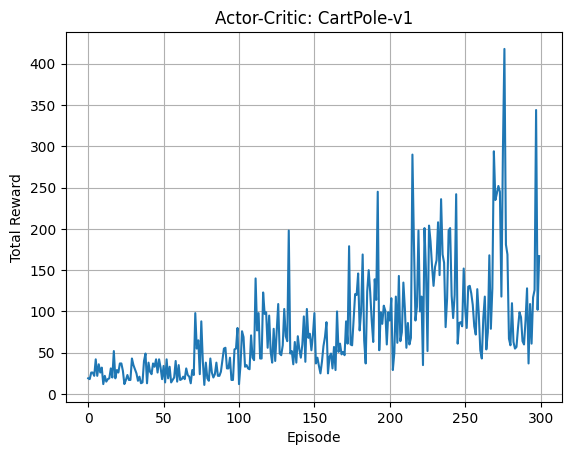

In [ ]:
import tensorflow as tf
import numpy as np
import gymnasium as gym  # 최신 gym 버전 (gymnasium) 사용 권장
import matplotlib.pyplot as plt
import imageio
import os
from IPython.display import Video

# 영상 저장 디렉토리
video_dir = './video'
os.makedirs(video_dir, exist_ok=True)

# 환경 설정 (render_mode 추가)
env = gym.make("CartPole-v1", render_mode='rgb_array')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# 정책 신경망 (Actor)
class Actor(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.d1 = tf.keras.layers.Dense(24, activation='relu')
        self.out = tf.keras.layers.Dense(action_size)

    def call(self, x):
        x = self.d1(x)
        return tf.nn.softmax(self.out(x))

# 가치 신경망 (Critic)
class Critic(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.d1 = tf.keras.layers.Dense(24, activation='relu')
        self.out = tf.keras.layers.Dense(1)

    def call(self, x):
        x = self.d1(x)
        return self.out(x)

actor = Actor()
critic = Critic()
actor_optimizer = tf.keras.optimizers.Adam(0.001)
critic_optimizer = tf.keras.optimizers.Adam(0.002)

def get_action(state):
    state = tf.convert_to_tensor([state], dtype=tf.float32)
    probs = actor(state)
    action = tf.random.categorical(tf.math.log(probs), 1)
    return int(action[0, 0]), probs[0]

def train_step(state, action, reward, next_state, terminated, truncated):
    state = tf.convert_to_tensor([state], dtype=tf.float32)
    next_state = tf.convert_to_tensor([next_state], dtype=tf.float32)

    with tf.GradientTape(persistent=True) as tape:
        v = critic(state)[0, 0]
        v_next = critic(next_state)[0, 0]
        target = reward + (1 - int(terminated or truncated)) * 0.99 * v_next
        td_error = target - v

        critic_loss = td_error**2

        probs = actor(state)
        log_prob = tf.math.log(probs[0, action] + 1e-8)
        actor_loss = -log_prob * td_error

    actor_grads = tape.gradient(actor_loss, actor.trainable_variables)
    critic_grads = tape.gradient(critic_loss, critic.trainable_variables)
    actor_optimizer.apply_gradients(zip(actor_grads, actor.trainable_variables))
    critic_optimizer.apply_gradients(zip(critic_grads, critic.trainable_variables))
    del tape

# 학습 루프
episodes = 300
scores = []

for ep in range(episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False
    while not done:
        action, _ = get_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        train_step(state, action, reward, next_state, terminated, truncated)
        state = next_state
        total_reward += reward
        done = terminated or truncated
    scores.append(total_reward)
    if (ep + 1) % 50 == 0:
        print(f"Episode {ep+1}: Total Reward = {total_reward}")

# 학습 결과 시각화
plt.plot(scores)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Actor-Critic: CartPole-v1")
plt.grid()
plt.show()

# ===========================
# 학습된 정책으로 테스트 후 영상 저장
# ===========================
frames = []
state, _ = env.reset()
done = False

while not done:
    frames.append(env.render())
    state_tensor = tf.convert_to_tensor([state], dtype=tf.float32)
    action_probs = actor(state_tensor).numpy()[0]
    action = np.argmax(action_probs) # 학습은 탐험과 이용을 사용하지만 평가는 반드시 최고의 행동을 선택한다.
    state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

video_path = os.path.join(video_dir, 'actor_critic_cartpole.mp4')

# Use imageio.get_writer to save the video
with imageio.get_writer(video_path, fps=30) as writer:
    for frame in frames:
        writer.append_data(frame)

# 노트북 내에서 영상 출력
Video(video_path, embed=True)

In [ ]:
!pip install "gymnasium[classic-control]"